# Business Case 3 - Recommender System

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from datetime import datetime

In [2]:
data = pd.read_csv("retail.csv")
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [3]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.describe(include = "all").T

C:\Users\emanu\AppData\Local\Temp\ipykernel_13100\598303432.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include = "all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,NaT,NaT,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaN,NaN,NaT,NaT,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaN,NaN,NaT,NaT,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0
Country,541909,38,United Kingdom,495478,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data exploration

In [5]:
data.isna().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
cancelations = data.loc[data["InvoiceNo"].str.contains("C")]
cancelations

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [7]:
#check consistency for cancelations, we shouldnt have any cancelations with quantity > 0
cancelations.loc[cancelations["Quantity"] > 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [8]:
#showing records not having customer id
data[data.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [9]:
# number of invoices not having at least one missing customer id value
len(data[data.CustomerID.isna()]["InvoiceNo"].unique())

3710

In [10]:
#checking dataset consistency - for each invoice only one customer id associated
grouped = data.groupby("InvoiceNo")["CustomerID"].value_counts(dropna = False)
grouped.index.value_counts()

(536365, 17850.0)     1
(571915, nan)         1
(571932, nan)         1
(571931, nan)         1
(571930, nan)         1
                     ..
(554107, 16249.0)     1
(554106, 12710.0)     1
(554105, 14711.0)     1
(554104, 12705.0)     1
(C581569, 17315.0)    1
Length: 25900, dtype: int64

In [11]:
#checking dataset consistency - for each stock code only one description associated
grouped = data.groupby("StockCode")["Description"].value_counts(dropna = False)
grouped.index.value_counts()

(10002, INFLATABLE POLITICAL GLOBE )         1
(46776C, WOVEN FROST CUSHION COVER)          1
(47343A, FUSCHIA FLOWER PURSE WITH BEADS)    1
(47341B, BLUE TABLE RUN FLOWER)              1
(47341A, nan)                                1
                                            ..
(22410, MONEY BOX HOUSEKEEPING DESIGN)       1
(22409, nan)                                 1
(22409, MONEY BOX BISCUITS DESIGN)           1
(22408, MONEY BOX CONFECTIONERY DESIGN)      1
(m, Manual)                                  1
Length: 5752, dtype: int64

In [12]:
#number of products having unit price to 0
print("# of rows having price 0 : ", len(data[data.UnitPrice == 0]))
print("# of products having price 0 : ", len(data[data.UnitPrice == 0]["StockCode"].unique()))

# of rows having price 0 :  2515
# of products having price 0 :  1419


In [13]:
#Reducing cardinality for Country
data.loc[data["Country"].value_counts()[data["Country"]].values < 500, "Country"] = "Others"

In [14]:
#checking if there are any duplicates by invoice number and date and stock code
data[data.duplicated(["InvoiceNo", "StockCode", "InvoiceDate"])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311.0,United Kingdom
498,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,1,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
502,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
525,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,2,2010-12-01 11:45:00,6.35,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,2011-12-09 11:34:00,0.65,14446.0,United Kingdom
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2011-12-09 11:34:00,5.45,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [15]:
#replacing duplicates with single record containing sum of all quantities for records that are going to be deleted
# tested, it works
data['Quantity'] = data.groupby(['InvoiceNo', 'StockCode'])['Quantity'].transform('sum')
data = data.drop_duplicates(subset=['InvoiceNo', 'StockCode'])

In [16]:
data[data.InvoiceNo == "581483"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [39]:
leverage = data[data["Quantity"] >= 0].groupby("CustomerID").sum()
leverage["TotalValueCustomer"] = leverage["Quantity"] * leverage["UnitPrice"]
leverage.sort_values("TotalValueCustomer", inplace = True, ascending=False)
leverage.reset_index(drop=False, inplace = True)
total_profit = leverage["TotalValueCustomer"].sum(axis = 0)
leverage["PercentProfit"] = (leverage["TotalValueCustomer"] / total_profit)
leverage

8570139955.384


,CustomerID,Quantity,UnitPrice,TotalValueCustomer,PercentProfit
0,14911.0,80515,26150.35,2.105495e+09,2.456781e-01
1,14646.0,197491,5176.09,1.022231e+09,1.192782e-01
2,14096.0,16352,33228.72,5.433560e+08,6.340107e-02
3,17841.0,23071,19092.75,4.404888e+08,5.139809e-02
4,16029.0,40208,8719.00,3.505736e+08,4.090640e-02
...,...,...,...,...,...
4334,17956.0,1,12.75,1.275000e+01,1.487724e-09
4335,14792.0,2,6.20,1.240000e+01,1.446884e-09
4336,16454.0,3,3.95,1.185000e+01,1.382708e-09
4337,16738.0,3,1.25,3.750000e+00,4.375658e-10


<AxesSubplot:ylabel='TotalValueCustomer'>

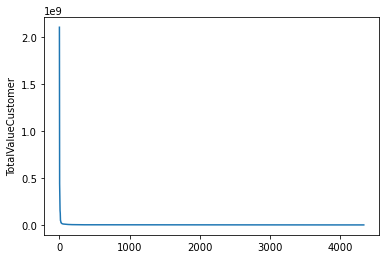

In [34]:
#Check Toghether results
sns.lineplot(x = leverage.index, y = leverage.TotalValueCustomer)

C:\Users\emanu\anaconda3\envs\bcases\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TotalValueCustomer'>

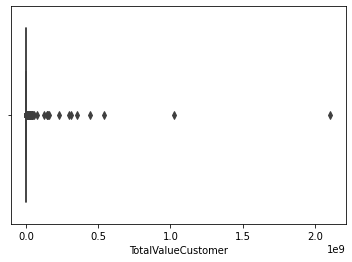

In [35]:
sns.boxplot(leverage["TotalValueCustomer"])

<AxesSubplot:ylabel='PercentProfit'>

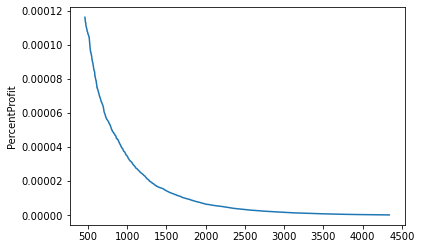

In [40]:
sns.lineplot(x = leverage[leverage.TotalValueCustomer < 1000000].index, y = leverage[leverage.TotalValueCustomer < 1000000].PercentProfit)